In [ ]:
!pip install torchdiffeq
!pip install torchmetrics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 40.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 47.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 9.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 33.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [ ]:
!pip install git+https://github.com/patrick-kidger/torchcubicspline.git

  Cloning https://github.com/patrick-kidger/torchcubicspline.git to /tmp/pip-req-build-ps31y2_c
  Running command git clone --filter=blob:none --quiet https://github.com/patrick-kidger/torchcubicspline.git /tmp/pip-req-build-ps31y2_c
  Resolved https://github.com/patrick-kidger/torchcubicspline.git to commit d16c6bf5b63d03dbf2977c70e19a320653b5e4a8
  Preparing metadata (setup.py) ... done
  Created wheel for torchcubicspline: filename=torchcubicspline-0.0.3-py3-none-any.whl size=12491 sha256=14ecd6153ba323986df6fafa45eb378a946970a31f4858131411c17011685dcc
  Stored in directory: /tmp/pip-ephem-wheel-cache-ax4_njds/wheels/ee/09/71/d32130a925eb2970905b02da57ae47b741c80c446d7f3049b6
Successfully built torchcubicspline


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import torch
from torchdiffeq import odeint_adjoint as odeint
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from scipy.stats import norm
from scipy.ndimage import gaussian_filter
from scipy.interpolate import interp1d
from scipy.signal import savgol_filter
from torchmetrics.regression import MeanSquaredError, MeanAbsoluteError
from numba import njit, prange
from sklearn.model_selection import train_test_split
from torchcubicspline import(natural_cubic_spline_coeffs,
                             NaturalCubicSpline)

### 1. SIMULATING DATA

In [ ]:
## simulating black scholes over S,T grid ##

In [ ]:
'''Global parameters'''
# General parameters
T = 1.0
r = 0.05
theta = 0.08
kappa = 6.3
xi    = 1.0
rho   = -0.8
v_0   = 0.02

In [ ]:
#Running the MC simulations based on the Heston Model
@njit(parallel=True)
def heston_mc_call(S0, tau, K, n_paths=10000, n_steps=100):
    if tau <= 0:
        return max(S0 - K, 0.0)
    dt = tau / n_steps
    sqrt_dt = np.sqrt(dt)
    # state arrays
    S = np.full(n_paths, S0, dtype=np.float64)
    v = np.full(n_paths, v_0, dtype=np.float64)

    #Euler-Maruyama scheme
    for _ in range(n_steps):
        Z1 = np.random.randn(n_paths)
        Z2 = np.random.randn(n_paths)
        dW_v = Z1 * sqrt_dt
        dW_S = (rho * Z1 + np.sqrt(1.0 - rho ** 2) * Z2) * sqrt_dt

        sqrt_v = np.sqrt(np.maximum(v, 0.0))
        v += kappa * (theta - v) * dt + xi * sqrt_v * dW_v
        v = np.maximum(v, 1e-10)
        S *= np.exp((r - 0.5 * v) * dt + np.sqrt(v) * dW_S)

    payoff = np.maximum(S - K, 0.0)
    return np.exp(-r * tau) * payoff.mean()

In [ ]:
#Values upon which I am building the grid
S_vals = np.linspace(0, 40, 64)
t_vals = np.linspace(0.0, 1.0, 64)
S, T_grid = np.meshgrid(S_vals, t_vals, indexing = 'ij')

In [ ]:
from tqdm import tqdm
def generate_heston_data(S_grid, T_grid, K):
    heston_data = np.zeros_like(S_grid)
    for i in tqdm(range(S_grid.shape[0]), desc="Computing Heston Surface"):
        for j in range(S_grid.shape[1]):
            S_t = S_grid[i, j]
            t = T_grid[i, j]
            tau = 1 - t
            heston_data[i, j] = heston_mc_call(S_t, tau, K)  # safe, fast call
    return heston_data

In [ ]:
heston_data = generate_heston_data(S, T_grid, K = 10)

Computing Heston Surface: 100%|██████████| 64/64 [05:23<00:00,  5.06s/it]


In [ ]:
print(heston_data.min(), heston_data.max())

0.0 30.0


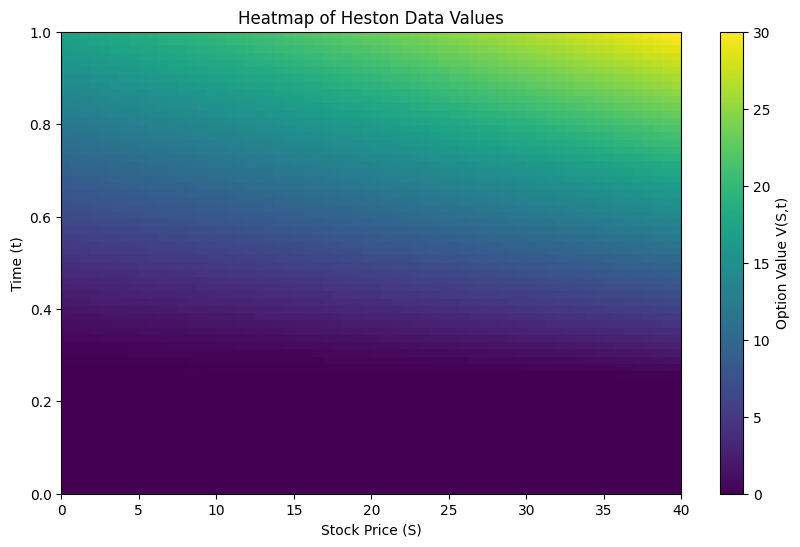

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(
    heston_data,
    extent=[S_vals.min(), S_vals.max(), t_vals.min(), t_vals.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

plt.colorbar(label="Option Value V(S,t)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time (t)")
plt.title("Heatmap of Heston Data Values")
plt.show()


### 2. BLACK SCHOLES THEORTICAL FORMULATION

In [ ]:
def bs_call_grid(S, t, r, sigma, T, K = 10):
    S = np.asarray(S, dtype=np.float64)
    t = np.asarray(t, dtype=np.float64)
    tau = np.clip(T - t, 0.0, None)
    intrinsic = np.maximum(S - K, 0.0)
    C = np.empty_like(S, dtype=np.float64)
    mask = tau > 0
    if np.any(mask):
        sqrt_tau = np.sqrt(tau[mask])
        eps = 1e-12
        S_safe = np.clip(S[mask], eps, None)
        print(S_safe.shape)
        d1 = (np.log(S_safe / K) + (r + 0.5 * sigma**2) * tau[mask]) / (sigma * sqrt_tau)
        d2 = d1 - sigma * sqrt_tau
        C[mask] = (
            S_safe * norm.cdf(d1) -
            K * np.exp(-r * tau[mask]) * norm.cdf(d2)
        )
        print(C.shape)
    C[~mask] = intrinsic[~mask]
    return C


In [ ]:
heston_data_smoothed = gaussian_filter(heston_data, sigma=0.5)
deltas = np.gradient(heston_data, S_vals, axis=1)
deltas = gaussian_filter(deltas, sigma=0.5)
gammas = np.gradient(deltas, S_vals, axis=1)
gammas = gaussian_filter(gammas, sigma=0.5)

torch.Size([64, 1])


/tmp/ipython-input-27-1217052499.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_at_tau = torch.tensor(gammas_spline.evaluate(tau), dtype=torch.float32).view(-1, 1)
/tmp/ipython-input-27-1217052499.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_at_tau = torch.tensor(deltas_spline.evaluate(tau), dtype=torch.float32).view(-1, 1)


(4032,)
(64, 64)
(64, 64)
RMSE: 0.027079913882041805
[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -3.48166814e-07  1.66514562e-07 -2.72478378e-07  2.42203001e-07
 -1.96789939e-07  3.17891438e-07 -1.21101500e-07  3.93579876e-07
 -4.54130635e-08  4.69268313e-07  3.02753733e-08  5.44956752e-07
 -8.47710503e-07 -3.33029128e-07  1.81652251e-07  6.96333625e-07
 -6.96333629e-07 -1.81652251e-07  3.33029124e-07  8.47710503e-07
 -5.44956755e-07 -3.02753769e-08  4.84406002e-07 -9.08261256e-07
 -3.93579878e-07  1.21101500e-07  6.35782875e-07 -7.56884379e-07
 -2.42203001e-07  2.72478374e-07  7.87159752e-07 -6.05507505e-07
 -9.08261271e-08  4.23855251e-07  9.38536626e-07  1.45321800e-06
  6.05507466e-08 -1.33211650e-06  1.08991350e-06 -3.02753755e-07
 -1.69542101e-06  7.26609002e-07 -6.6

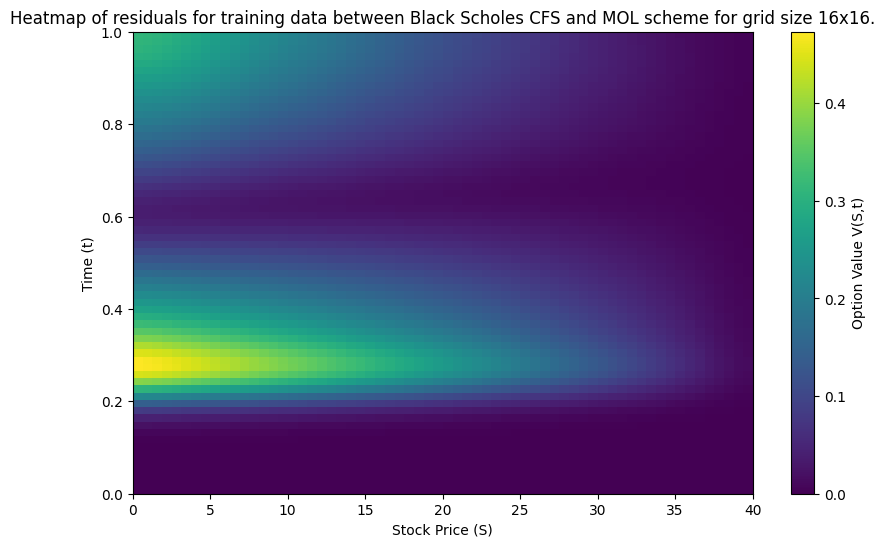

0.7727372588495856


In [ ]:
## terminal/initial condition ##
S_vals_tensor = torch.tensor(S_vals, dtype = torch.float32)
terminal_conditions = torch.maximum(S_vals_tensor - 10, torch.tensor(0)).unsqueeze(1)
print(terminal_conditions.shape)
diagonal_S = torch.diag(S_vals_tensor)
S_squared = diagonal_S @ diagonal_S

time = torch.linspace(0, 1, 64)
deltas_torch = torch.tensor(deltas)
gammas_torch = torch.tensor(gammas)
#interpolating through the gammas and deltas matrices to get the gradients at any time returned by solver
deltas_coeffs = natural_cubic_spline_coeffs(time, deltas_torch.T)
deltas_spline = NaturalCubicSpline(deltas_coeffs)

gammas_coeffs = natural_cubic_spline_coeffs(time, gammas_torch.T)
gammas_spline = NaturalCubicSpline(gammas_coeffs)


# gamma_interp = interp1d(time, gammas, axis=1, kind='cubic', fill_value = 'extrapolate')
# delta_interp = interp1d(time, deltas, axis=1, kind='cubic', fill_value = 'extrapolate')

sigma = np.sqrt(v_0)

def RHS(t, V):
    tau = 1 - t
    gamma_at_tau = torch.tensor(gammas_spline.evaluate(tau), dtype=torch.float32).view(-1, 1)
    delta_at_tau = torch.tensor(deltas_spline.evaluate(tau), dtype=torch.float32).view(-1, 1)
    dVdtau = 0.5 * sigma**2 * (S_squared @ gamma_at_tau) + r * (diagonal_S @ delta_at_tau) - (r * V)
    return -dVdtau

pure_solutions = odeint(RHS, terminal_conditions, time, method='dopri5', adjoint_params=())
pure_solutions_np = pure_solutions.squeeze(-1).detach().numpy()  # shape (T, S)
pure_solutions_np = np.flip(pure_solutions_np, axis=0)      # now tau = 1 → 0

bs_option_values = bs_call_grid(S, T_grid, r, sigma, T, K=10)

# Now shape = (T, S), flip → (T, S), transpose → (S, T)
pure_solutions_final = pure_solutions_np.T
print(pure_solutions_final.shape)
print("RMSE:",np.sqrt(np.mean(bs_option_values - pure_solutions_final)**2))
#print("RMSE:",np.sqrt(np.mean(gbm_data - pure_solutions_final)**2))

## sanity check ##
print(bs_option_values[:,-1] - pure_solutions_final[:,-1])
residuals = np.abs(bs_option_values - pure_solutions_final)
plt.figure(figsize=(10, 6))
plt.imshow(
    gaussian_filter(residuals, sigma = 2.5),
    extent=[S_vals.min(), S_vals.max(), t_vals.min(), t_vals.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

plt.colorbar(label="Option Value V(S,t)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time (t)")
plt.title("Heatmap of residuals for training data between Black Scholes CFS and MOL scheme for grid size 16x16.")
plt.show()


print(residuals.max())

In [ ]:
print('MSE between FDM scheme and heston data:', np.mean((pure_solutions_final - heston_data)**2))
print('MSE between closed form solution scheme and heston data:', np.mean((bs_option_values - heston_data)**2))
print('MSE between closed form solution scheme and FDM scheme:', np.sqrt(np.mean((pure_solutions_final - bs_option_values)**2)))

MSE between FDM scheme and heston data: 21.078155931546945
MSE between closed form solution scheme and heston data: 20.799230837503632
MSE between closed form solution scheme and FDM scheme: 0.14353677932288064


### 3. Neural Black Scholes Model

In [ ]:
#1. Change input to neural network model (just training on entire data no testing at all)
class NeuralBlackScholesWithChangedInput(nn.Module):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(nn.Linear(3,16),nn.Tanh(),nn.Linear(16,1))
        self.S_2 = None
        self.S = None
        self.S_vals = None
        self.gamma = None
        self.delta = None
        self.time = None

    def input(self, S_values,  delta, gamma, time):
        self.S_vals = S_values
        self.S = torch.diag(S_values)
        self.S_2 = self.S @ self.S
        self.delta = torch.tensor(delta)
        self.gamma = torch.tensor(gamma)
        self.time = time

    def forward(self, t, V):
        tau = 1 - t
        #interpolation
        deltas_coeffs = natural_cubic_spline_coeffs(self.time, self.gamma.T)
        deltas_spline = NaturalCubicSpline(deltas_coeffs)
        gammas_coeffs = natural_cubic_spline_coeffs(self.time, self.delta.T)
        gammas_spline = NaturalCubicSpline(gammas_coeffs)
        gamma_at_tau = gammas_spline.evaluate(tau).to(torch.float32).unsqueeze(1)
        delta_at_tau = deltas_spline.evaluate(tau).to(torch.float32).unsqueeze(1)
        #passing the time as an input
        time_vector = torch.full_like(self.S_vals, tau.item()).unsqueeze(1)
        #giving initial volatility as input to neural network to see if it learns better
        initial_volatilities = torch.full_like(self.S_vals, v_0).unsqueeze(1)
        features_at_tau = torch.cat([initial_volatilities, self.S_vals.unsqueeze(1), time_vector], dim=1)
        output = self.network(features_at_tau)
        dVdtau = (0.5 * sigma**2 * (self.S_2 @ gamma_at_tau) + r * (self.S @ delta_at_tau) - r * V + output)
        return -dVdtau

In [ ]:
model = NeuralBlackScholesWithChangedInput()
time = torch.linspace(0, 1, 16)
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
epochs = 50
loss_function = nn.MSELoss()
training_losses = []
data = torch.tensor(heston_data, dtype = torch.float32)
for itr in range(epochs):
    print('Epoch', itr)
    print('Starting Training')
    model.train()
    optimizer.zero_grad()
    model.input(S_vals_tensor, deltas, gammas, time)
    v_pred = odeint(model, terminal_conditions, time, method = 'dopri5').squeeze(2)
    v_pred_flip = torch.flip(v_pred,dims = [0])
    v_pred = v_pred_flip.T
    loss = loss_function(v_pred, data)
    #print("Loss:",loss)
    ## sanity check ##
    #print(v_pred.shape)
    #print(v_pred[:,-1] - data[:,-1])
    #break
    loss.backward()
    optimizer.step()
    print('Training loss:', loss.item())
    print('Ending Training')


Epoch 0
Starting Training
Training loss: 16.9027099609375
Ending Training
Epoch 1
Starting Training
Training loss: 16.11136817932129
Ending Training
Epoch 2
Starting Training
Training loss: 15.373013496398926
Ending Training
Epoch 3
Starting Training
Training loss: 14.676518440246582
Ending Training
Epoch 4
Starting Training
Training loss: 14.013412475585938
Ending Training
Epoch 5
Starting Training
Training loss: 13.377626419067383
Ending Training
Epoch 6
Starting Training
Training loss: 12.763705253601074
Ending Training
Epoch 7
Starting Training
Training loss: 12.167156219482422
Ending Training
Epoch 8
Starting Training
Training loss: 11.583043098449707
Ending Training
Epoch 9
Starting Training
Training loss: 11.00666618347168
Ending Training
Epoch 10
Starting Training
Training loss: 10.436038970947266
Ending Training
Epoch 11
Starting Training
Training loss: 9.875611305236816
Ending Training
Epoch 12
Starting Training
Training loss: 9.339780807495117
Ending Training
Epoch 13
Starti

In [ ]:
'''So the model is most certainly learning.'''

'So the model is most certainly learning.'

### 3.1 Training, validating and testing

In [ ]:
'''Starting training validation and testing'''

'Starting training validation and testing'

In [ ]:
'''Here we create and split the heston new data set (different initial condition and terminal but same stock dynamics)
into validation & test.
In the loop we
1. Train - Entire of heston data (original dataset)
2. Val - 70% of heston new data
3. Test - 30% of heston new data'''

'Here we create and split the heston new data set (different initial condition and terminal but same stock dynamics)\ninto validation & test.\nIn the loop we\n1. Train - Entire of heston data (original dataset)\n2. Val - 70% of heston new data\n3. Test - 30% of heston new data'

In [ ]:
#Values upon which I am building the grid
S_new = np.linspace(5, 50, 512)
t_new = np.linspace(0.0, 1.0, 512)
S_new_grid, T_new_grid = np.meshgrid(S_new, t_new, indexing = 'ij')

In [ ]:
heston_new_data = generate_heston_data(S_new_grid, T_new_grid, K = 15)

Computing Heston Surface: 100%|██████████| 512/512 [5:45:15<00:00, 40.46s/it]


### 3.1.1 Checking that implementation of validation set is correct

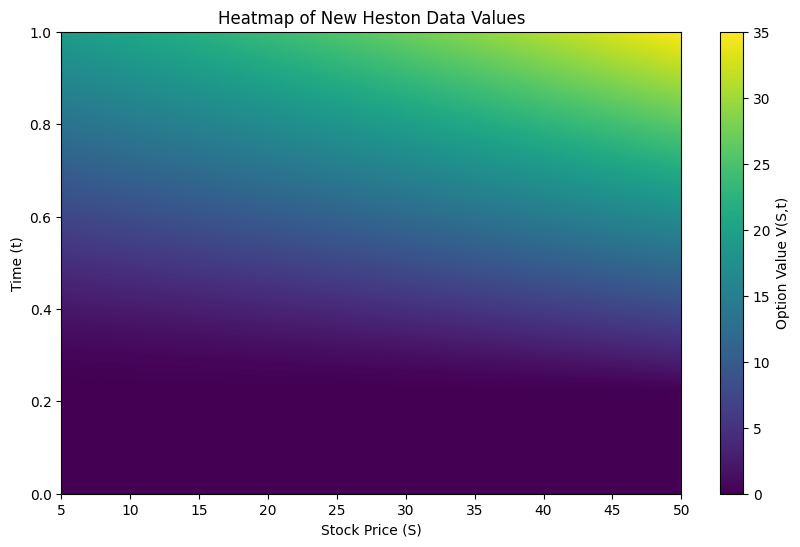

In [ ]:
plt.figure(figsize=(10, 6))
plt.imshow(
    heston_new_data,
    extent=[S_new_grid.min(), S_new_grid.max(), T_new_grid.min(), T_new_grid.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

plt.colorbar(label="Option Value V(S,t)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time (t)")
plt.title("Heatmap of New Heston Data Values")
plt.show()


In [ ]:
heston_new_data_smoothed = gaussian_filter(heston_new_data, sigma=0.5)
deltas_new = np.gradient(heston_new_data_smoothed, S_new, axis=1)
deltas_new = gaussian_filter(deltas_new, sigma=0.5)
gammas_new = np.gradient(deltas_new, S_new, axis=1)
gammas_new = gaussian_filter(gammas_new, sigma=0.5)

In [ ]:
print(deltas_new.shape)

(512, 512)


In [ ]:
bs_option_values_new = bs_call_grid(S_new_grid, T_new_grid, r, sigma, T, K=15)

(261632,)
(512, 512)


torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])
torch.Size([512, 512])


/tmp/ipython-input-68-3572648885.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gamma_at_tau_new = torch.tensor(gammas_spline_new.evaluate(tau), dtype=torch.float32).view(-1, 1)
/tmp/ipython-input-68-3572648885.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  delta_at_tau_new = torch.tensor(deltas_spline_new.evaluate(tau), dtype=torch.float32).view(-1, 1)


Option values [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.       

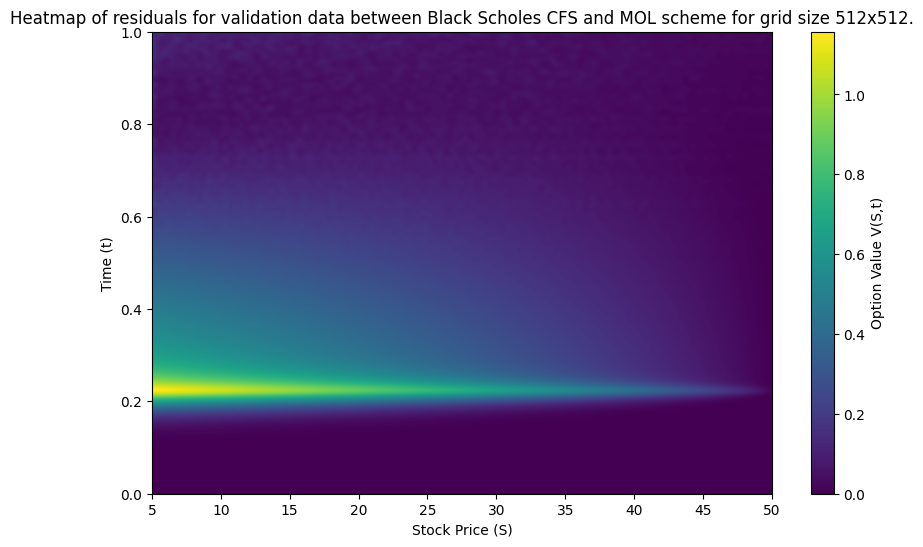

1.220304773179441


In [ ]:
## terminal/initial condition ##
S_new_tensor = torch.tensor(S_new, dtype = torch.float32)
terminal_conditions_new = torch.maximum(S_new_tensor - 15, torch.tensor(0)).unsqueeze(1)
diagonal_S_new = torch.diag(S_new_tensor)
S_squared_new = diagonal_S_new @ diagonal_S_new
time_new = torch.linspace(0, 1, 512)
deltas_torch_new = torch.tensor(deltas_new)
gammas_torch_new = torch.tensor(gammas_new)
#shapes of the deltas, gammas, S_squared, diagonal_S_new
print(gammas_torch_new.shape)
print(deltas_torch_new.shape)
print(S_squared_new.shape)
print(diagonal_S_new.shape)
#interpolating through the gammas and deltas matrices to get the gradients at any time returned by solver
deltas_coeffs_new = natural_cubic_spline_coeffs(time_new, deltas_torch_new.T)
deltas_spline_new = NaturalCubicSpline(deltas_coeffs_new)
gammas_coeffs_new = natural_cubic_spline_coeffs(time_new, gammas_torch_new.T)
gammas_spline_new = NaturalCubicSpline(gammas_coeffs_new)

# gamma_interp = interp1d(time, gammas, axis=1, kind='cubic', fill_value = 'extrapolate')
# delta_interp = interp1d(time, deltas, axis=1, kind='cubic', fill_value = 'extrapolate')

sigma = np.sqrt(v_0)

def RHS_new(t, V):
    tau = 1 - t
    gamma_at_tau_new = torch.tensor(gammas_spline_new.evaluate(tau), dtype=torch.float32).view(-1, 1)
    delta_at_tau_new = torch.tensor(deltas_spline_new.evaluate(tau), dtype=torch.float32).view(-1, 1)
    dVdtau_new = 0.5 * sigma**2 * (S_squared_new @ gamma_at_tau_new) + r * (diagonal_S_new @ delta_at_tau_new) - (r * V)
    return -dVdtau_new

pure_solutions_new = odeint(RHS_new, terminal_conditions_new, time_new, method='dopri5', adjoint_params=())
pure_solutions_np_new = pure_solutions_new.squeeze(-1).detach().numpy()  # shape (T, S)
pure_solutions_np_new = np.flip(pure_solutions_np_new, axis=0)      # now tau = 1 → 0

# Now shape = (T, S), flip → (T, S), transpose → (S, T)
pure_solutions_final_new = pure_solutions_np_new.T
print('Option values', pure_solutions_final_new[:, -1])
print('black Scholes values', bs_option_values_new[:, -1])
print("RMSE:",np.sqrt(np.mean(bs_option_values_new - pure_solutions_final_new)**2))


##sanity check ##
residuals_new = np.abs(bs_option_values_new - pure_solutions_final_new)
plt.figure(figsize=(10, 6))
plt.imshow(
    gaussian_filter(residuals_new, sigma = 2.5),
    extent=[S_new.min(), S_new.max(), t_new.min(), t_new.max()],
    origin='lower',
    aspect='auto',
    cmap='viridis'
)

plt.colorbar(label="Option Value V(S,t)")
plt.xlabel("Stock Price (S)")
plt.ylabel("Time (t)")
plt.title("Heatmap of residuals for validation data between Black Scholes CFS and MOL scheme for grid size 512x512.")
plt.show()
print(residuals_new.max())

In [ ]:
print('MSE between FDM scheme and heston data:', np.mean((pure_solutions_final_new - heston_new_data)**2))
print('MSE between closed form solution scheme and heston data:', np.mean((bs_option_values_new - heston_new_data)**2))
print('MSE between closed form solution scheme and FDM scheme:', np.mean((pure_solutions_final_new - bs_option_values_new)**2))

MSE between FDM scheme and heston data: 33.4768903195374
MSE between closed form solution scheme and heston data: 34.49953739372581
MSE between closed form solution scheme and FDM scheme: 0.05550780898673745


### 3.1.2 Implementing Train, validation and testing

In [ ]:
#This is just training on entire original dataset and validating on entire new set.

In [ ]:
#Splitting the original dataset into train and test and then validation on entire new dataset

In [ ]:
# Split: 80% train, 20% test, validate on other data set
data = torch.tensor(heston_data, dtype = torch.float32)
time = torch.linspace(0, 1, 16)

#Training
train_data = data[:, 0: int(0.8*len(data))]
terminal_conditions_train = train_data[:, -1].unsqueeze(1)
time_train = time[0: int(0.8*len(data))]

#Validation
val_data = torch.tensor(heston_new_data)
terminal_conditions_val = val_data[:, -1].unsqueeze(1)
time_val = torch.tensor(t_new, dtype = torch.float32)

#Testing
test_data = data[:, int(0.8*len(data)):]
terminal_conditions_test = test_data[:, -1].unsqueeze(1)
time_test = time[int(0.8*len(data)):]

print("Terminal conditions of train, val & test:", terminal_conditions_train.shape, terminal_conditions_val.shape, terminal_conditions_test.shape)
print("Data sizes of train, val & test:", train_data.shape, val_data.shape, test_data.shape)
print("Time sizes of train, val & test:", time_train.shape, time_val.shape, time_test.shape)

Terminal conditions of train, val & test: torch.Size([16, 1]) torch.Size([512, 1]) torch.Size([16, 1])
Data sizes of train, val & test: torch.Size([16, 12]) torch.Size([512, 512]) torch.Size([16, 4])
Time sizes of train, val & test: torch.Size([12]) torch.Size([512]) torch.Size([4])


In [ ]:
model = NeuralBlackScholesWithChangedInput()
optimizer = torch.optim.Adam(model.parameters(), lr = 1e-2)
epochs = 50
loss_function = nn.MSELoss()
training_losses = []
validation_losses = []
for itr in range(epochs):
    print('Epoch', itr)
    print('Starting Training')
    model.train()
    optimizer.zero_grad()
    model.input(S_vals_tensor, deltas, gammas, time)
    v_pred_train = odeint(model, terminal_conditions_train, time_train, method = 'dopri5').squeeze(2)
    v_pred_flip_train = torch.flip(v_pred_train,dims = [0])
    v_pred_train = v_pred_flip_train.T
    loss = loss_function(v_pred_train, train_data)
    loss.backward()
    optimizer.step()
    print('Training loss:', loss.item())
    training_losses.append(loss.item())
    with torch.no_grad():
        model.input(torch.tensor(S_new, dtype = torch.float32), deltas_new, gammas_new, time_val)
        v_pred_val = odeint(model, terminal_conditions_val, time_val, method = 'dopri5').squeeze(2)
        v_pred_flip_val = torch.flip(v_pred_val,dims = [0])
        v_pred_val = v_pred_flip_val.T
        val_loss = loss_function(v_pred_val, val_data)
        print('Validation loss:', val_loss.item())
        validation_losses.append(val_loss.item())
print('Ending Training')
torch.save(model.state_dict(), 'black_scholes_model_weights.pth')

NameError: name 'NeuralBlackScholesWithChangedInput' is not defined

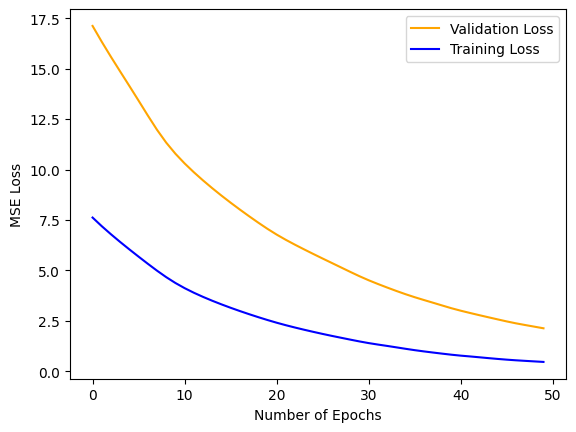

In [ ]:
plt.figure()
plt.plot(validation_losses, color = 'orange', label = 'Validation Loss')
plt.plot(training_losses, color = 'blue', label = 'Training Loss')
plt.xlabel('Number of Epochs')
plt.ylabel('MSE Loss')
plt.legend()
plt.show()

In [ ]:
model.input(S_vals_tensor, deltas, gammas, time)
model.load_state_dict(torch.load('black_scholes_model_weights.pth'))
v_pred_test = odeint(model, terminal_conditions_test, time_test, method = 'dopri5').squeeze(2)
v_pred_flip_test = torch.flip(v_pred_test,dims = [0])
v_pred_test = v_pred_flip_test.T
test_loss = loss_function(v_pred_test, test_data)
print('Test model loss:', test_loss.item())
S_test, T_test = np.meshgrid(S_vals, time_test, indexing = 'ij')
bs_option_values_test = bs_call_grid(S_test, T_test, r, sigma, T, K=15)
print(bs_option_values_test.shape)
print(test_data.shape)
cfs_loss = loss_function(torch.tensor(bs_option_values_test), test_data)
print('Test CFS loss:', cfs_loss.item())

Test model loss: 0.13958735764026642
(3200,)
(128, 26)
(128, 26)
torch.Size([128, 26])
Test CFS loss: 10.616619059306649
